# De-novo signature inference and activity estimation

In [44]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import damuta as da
import seaborn as sns
import matplotlib.pyplot as plt
from damuta.plotting import plot_damage_signatures, plot_misrepair_signatures

In [45]:
# Load data for 100 patients
counts = pd.read_csv('example_data/pcawg_counts.csv', index_col=0).head(100)
annotation = pd.read_csv('example_data/pcawg_cancer_types.csv', index_col=0).head(100)
pcawg = da.DataSet(counts, annotation)

When there is no fixed signature definition provided, DAMUTA will estimate parameters for both the signature activities, and the signature definitions themselves. 

We can help regularize this by putting strong sparsity priors on the distributions of the signature definitions (pi, lambda) and on the activity distributions (psi, priors on gamma)

In [46]:
ht_lda = da.models.HierarchicalTandemLda(pcawg, type_col = 'pcawg_class', n_damage_sigs = 5, n_misrepair_sigs = 3)
ht_lda._build_model(**ht_lda._model_kwargs)

In [47]:
ht_lda.fit(n=10000)

Interrupted at 6,931 [69%]: Average Loss = 1.3702e+06


Check ELBO for convergence

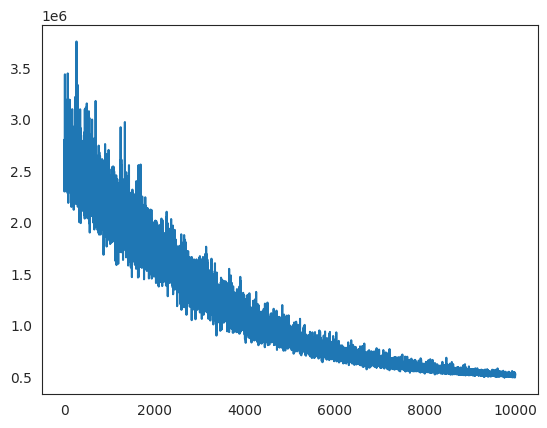

In [23]:
plt.plot(ht_lda.approx.hist)

Let's have a look at the inferred signature definitions. These have been estimated from only 100 samples for demonstration purposes.

In [24]:
denovo_sigs = ht_lda.get_estimated_SignatureSet()

Damage signatures

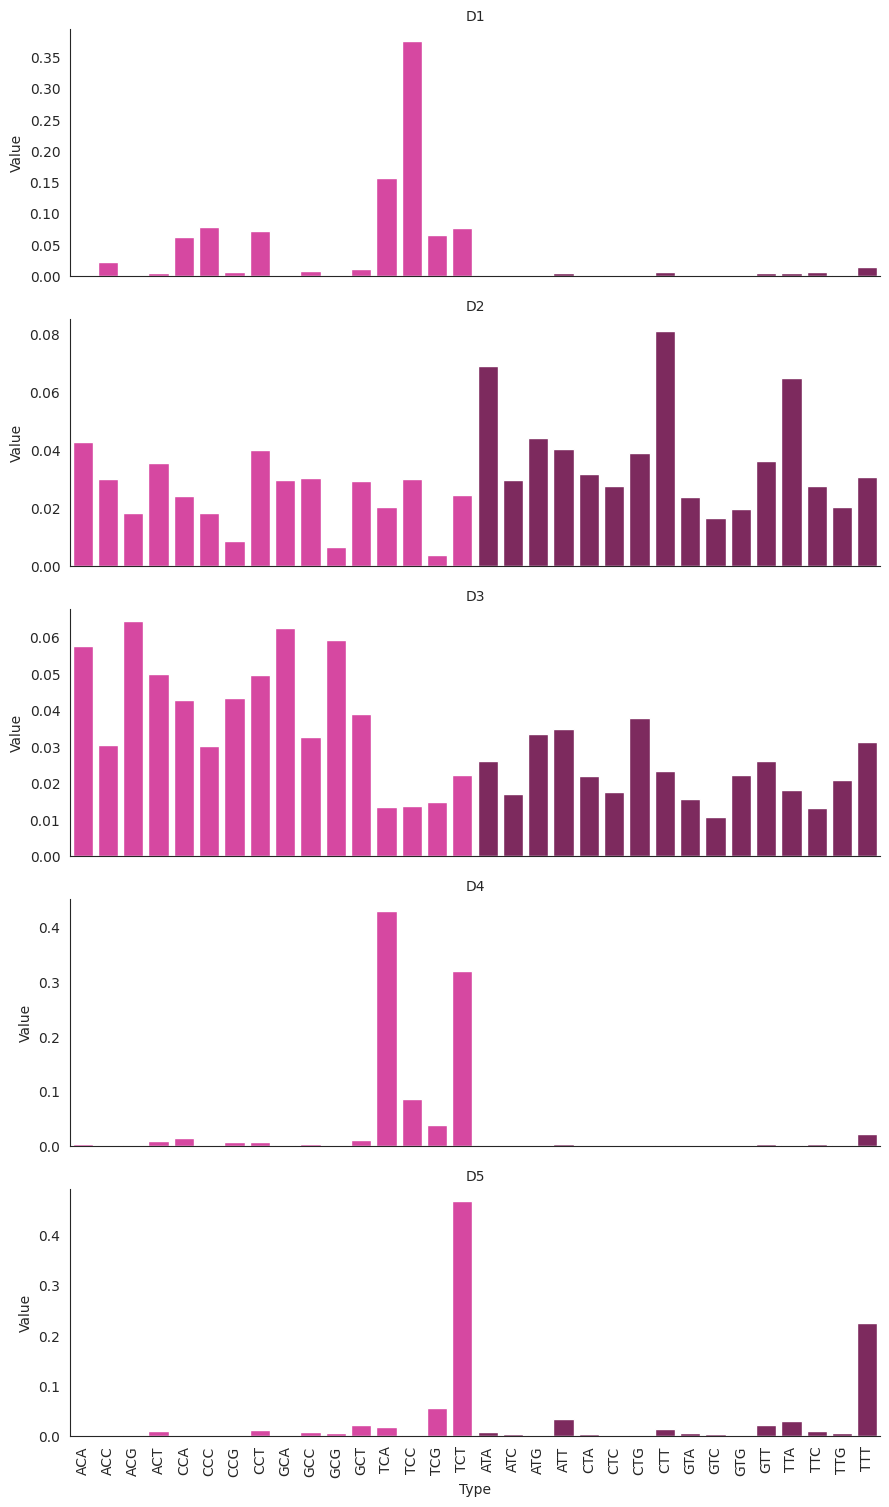

In [ ]:
plot_damage_signatures(denovo_sigs.damage_signatures)


Misrepair signatures

nb. there are only six substitution classes - this means that you probably don't ever need more than six misrepair signautres in your model

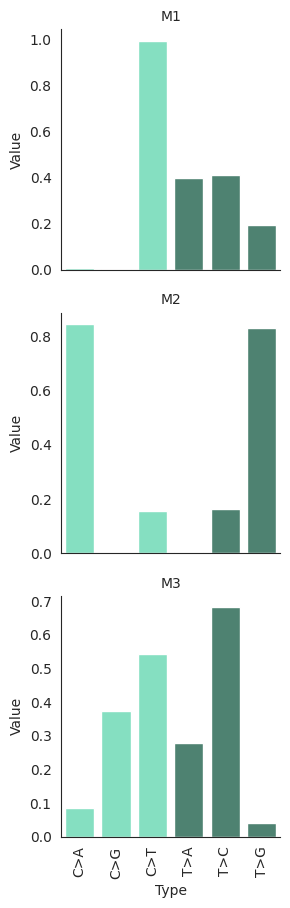

In [26]:
plot_misrepair_signatures(denovo_sigs.misrepair_signatures)

## Options for initializing signatures

* **Uniformly at random**
* **From k-means of the data**: preferred for speed + stability
* **From a signature set**: this will encourage signatures to be similar to the set, but not fix them in the model, meaning the definitions are allowed to drift over the course of training. In contrast to the example in quickstart, where signature definitions are fixed.

## How many signatures to fit?

You can use [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for model selection. More signautres will usually give a higher likelihood, and BIC penalizes adding these extra parameters. 


We use the product of multinomial likelihoods to get the total probability of mutation counts in the dataset; when there are many samples this will be a very small number (large negative log value)

In [38]:
trace = ht_lda.approx.sample(3)  # Sample from posterior
log_likelihood = np.array(list(da.utils.mult_ll(pcawg.counts, b) for b in trace.B)).sum(1).mean()
print(round(log_likelihood, 2))
print("for 100 samples, this is a log likelihood of approx.", round(log_likelihood/100, 2), "per sample")

-518178.83
for 100 samples, this is a log likelihood of approx. -5181.79 per sample


In [40]:
BIC = ht_lda.model.ndim * np.log(pcawg.n_samples) - 2 * log_likelihood  # BIC calculation
print(round(BIC, 2))

1048432.43
